<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [143]:
!pip install scikit-learn -q

We will import the following libraries for the lab


In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

This function is to plot the confusion matrix.


In [145]:
def plot_confusion_matrix(y,y_predict, save: bool=False) -> None:
    "this function plots the confusion matrix"

    cm = confusion_matrix(y, y_predict)
    dpi = 100
    if save:
        dpi = 150
    plt.figure(dpi=dpi)  # Set the DPI for the entire figure
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Did not land', 'Landed']); ax.yaxis.set_ticklabels(['Did not land', 'Landed']) 
    plt.tight_layout()
    if save:
        plt.savefig("eda_plots/confusion_matrix.png")
    plt.show() 

## Load the dataframe


Load the data


In [146]:
import requests
import io

URL1 = (
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/"
    "IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
)
response_1 = requests.get(URL1, timeout=2)
if response_1.ok:
    text1 = io.BytesIO(response_1.content)
    data = pd.read_csv(text1)
else:
    print(f"Failed to get {URL1}, responce code: {response_1.status_code}")

In [147]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [148]:
URL2 = (
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/"
    "IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv"
)
response_2 = requests.get(URL2, timeout=2)
assert response_2.ok, print(response_2.status_code)
text2 = io.BytesIO(response_2.content)
X = pd.read_csv(text2)

In [149]:
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [150]:
Y = data['Class'].to_numpy()

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [151]:
# students get this 
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [152]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [153]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [154]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [155]:
lr=LogisticRegression()
# Create a GridSearchCV object
logreg_cv = GridSearchCV(lr, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [156]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [157]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

Lets look at the confusion matrix:


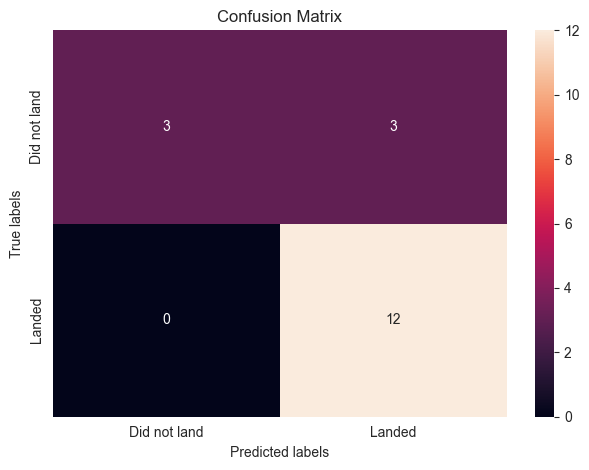

In [158]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [159]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [160]:
# Create a GridSearchCV object
svm_cv = GridSearchCV(svm, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [161]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [162]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


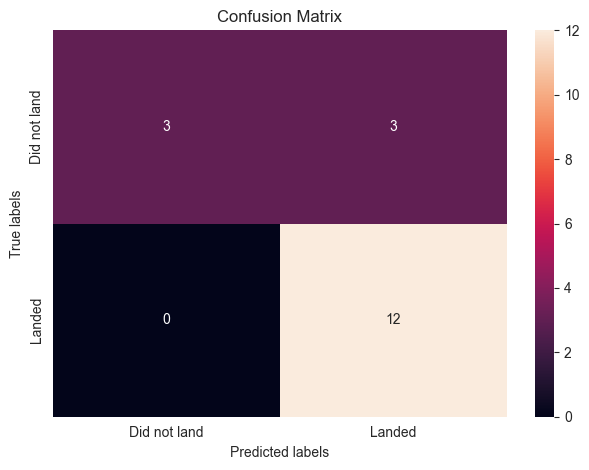

In [163]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [164]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2 * n for n in range(1, 10)],
    'max_features': [None, 'sqrt', 'log2'],  # 'auto' is replaced with None
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

tree = DecisionTreeClassifier()

In [165]:
# Create a GridSearchCV object
tree_cv = GridSearchCV(tree, parameters, cv=10)

# Fit the GridSearchCV object to find the best parameters
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [166]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.8767857142857143


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [167]:
tree_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


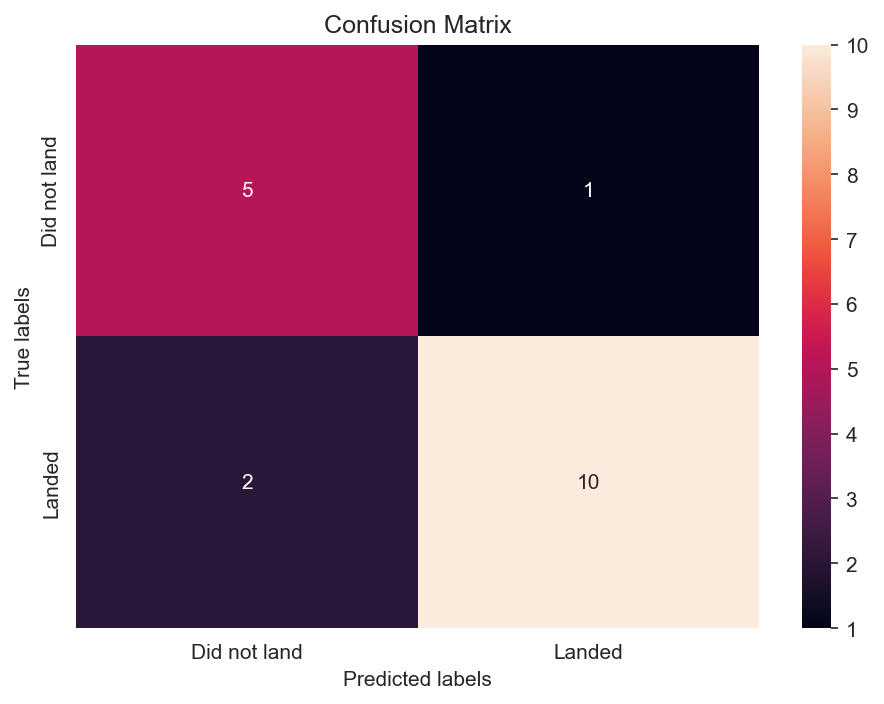

In [168]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat, True)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [169]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [170]:
# Create a GridSearchCV object
knn_cv = GridSearchCV(KNN, parameters, cv=10)

# Fit the GridSearch object to find the best parameters
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [171]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [172]:
knn_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


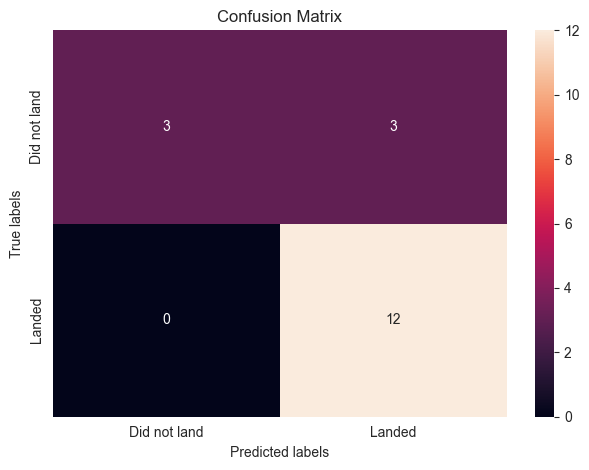

In [173]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:


In [174]:
from sklearn.metrics import precision_score, recall_score
import time

# Define a function to train and evaluate a model, and return the time taken
def train_and_evaluate(model, X_train, Y_train, X_test, Y_test):
    start_time = time.time()
    model.fit(X_train, Y_train)
    training_time = time.time() - start_time
    
    # Predictions on the test set
    y_pred = model.predict(X_test)
    
    accuracy = model.best_score_.round(5)
    test_acc = model.score(X_test, Y_test).round(5)

    # Calculate precision and recall
    precision = precision_score(Y_test, y_pred, average='binary')
    recall = recall_score(Y_test, y_pred, average='binary')
    
    return accuracy, test_acc, round(precision, 4), round(recall, 4), round(training_time, 4)

comparison = {
    'Name': ['Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'Time'],
    'LogReg': [],
    'SVM': [],
    'Tree': [],
    'KNN': []
}
for name, model in [('LogReg', logreg_cv), ('SVM', svm_cv), ('Tree', tree_cv), ('KNN', knn_cv)]:
    comparison[name] = train_and_evaluate(model, X_train, Y_train, X_test, Y_test)

comp_df = pd.DataFrame(comparison).T

# Assigning columns
comp_df.columns = comp_df.iloc[0]
comp_df = comp_df[1:]

In [175]:
# Calculate F1 score
def calculate_f1(precision, recall):
    if all(precision + recall) == 0:
        return 0  # Handle the case where both precision and recall are zero
    return 2 * (precision * recall) / (precision + recall)

In [176]:
comp_df['F1 score'] = calculate_f1(comp_df['Precision'], comp_df['Recall'])
comp_df

Name,Accuracy,Test Accuracy,Precision,Recall,Time,F1 score
LogReg,0.84643,0.83333,0.8,1.0,0.0455,0.888889
SVM,0.84821,0.83333,0.8,1.0,0.8072,0.888889
Tree,0.87679,0.83333,0.8,1.0,4.3201,0.888889
KNN,0.84821,0.83333,0.8,1.0,0.5880,0.888889


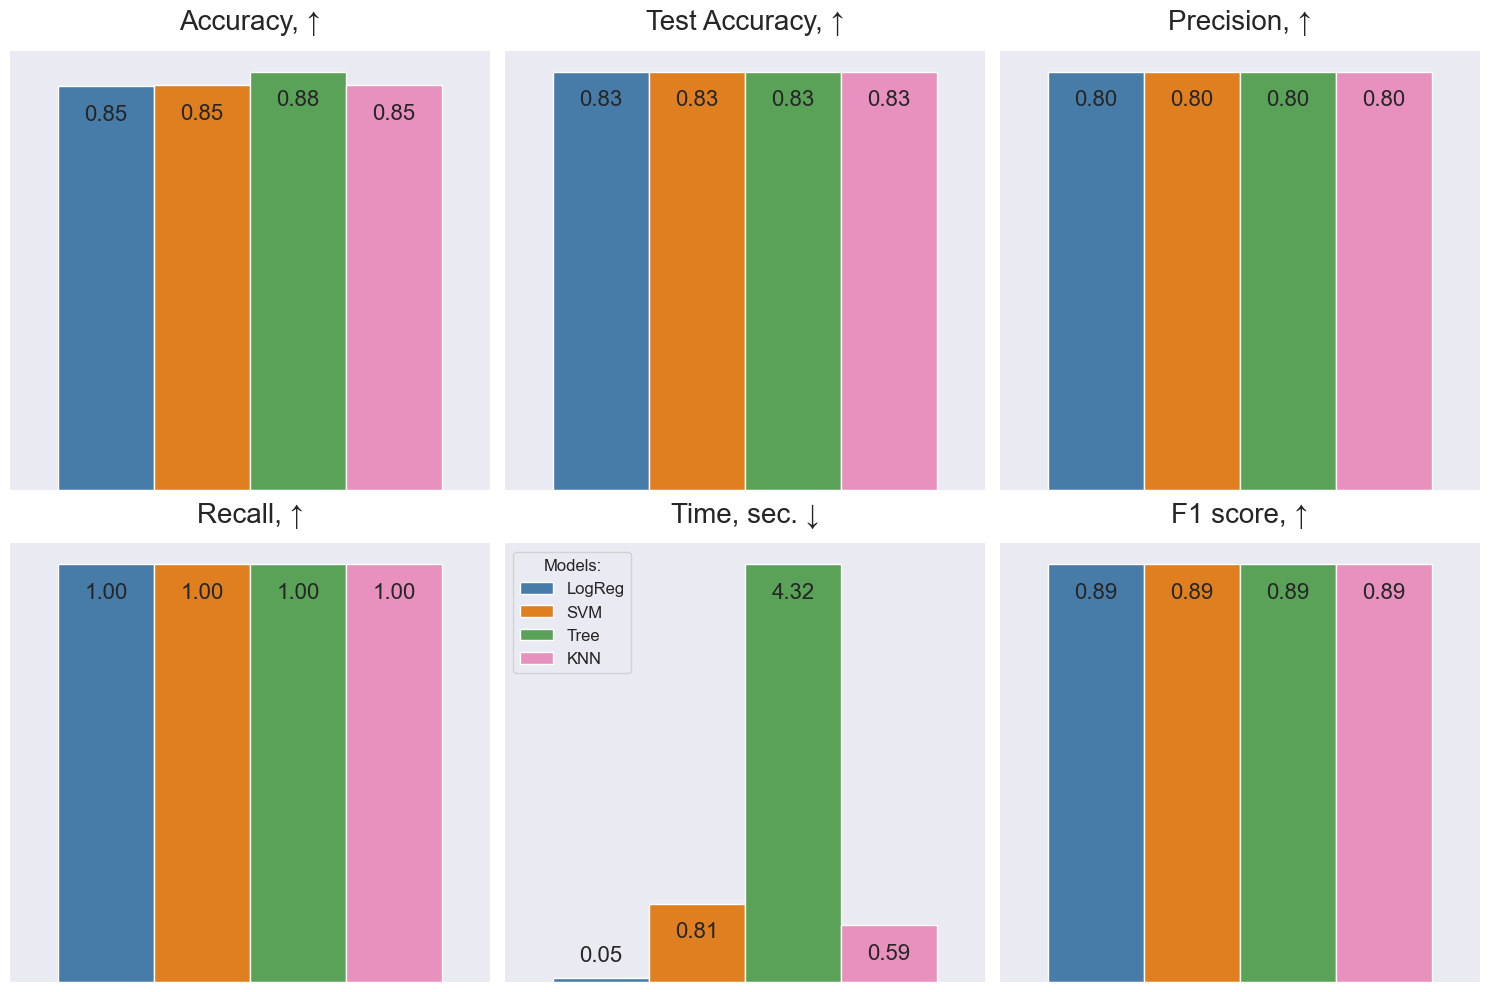

In [177]:
# Set the figure size
plt.figure(figsize=(15, 10), dpi=100)

sns.set_style("dark")

# Use colorblind friendly pallete
color_scheme = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf']

# Create subplots for each metric
metrics = ["Accuracy", "Test Accuracy", "Precision", "Recall", "Time", "F1 score"]
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)

    if metric == "Time":
        # Use hue for the time comparison subplot
        ax = sns.barplot(hue=comp_df.index, y=metric, data=comp_df, palette=color_scheme)
        plt.legend(
            title="Models:", loc="upper left", fontsize="large", title_fontsize="large"
        )
        plt.title(f"{metric}, sec. ↓", y=1.03, size=20)
    else:
        ax = sns.barplot(
            hue=comp_df.index, y=metric, data=comp_df, palette=color_scheme, legend=False
        )
        plt.title(f"{metric}, ↑", y=1.03, size=20)
    
    plt.xlabel(None)
    plt.ylabel(None)

    # Despine the top and right axes
    sns.despine(top=True, right=True, left=True)

    # Remove ticks
    plt.xticks([])
    plt.yticks([])

    # Add values on each bar
    for p in ax.patches:
        # Check the value of the bar if it's too low, the value will be printed above the bar
        abs_sign = -1
        if p.get_height() < 0.1:
            abs_sign = 0.8
        # Get rid of 0.0 text on Time subplot
        if p.get_height() == 0 and p.get_width() == 0:
            continue
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, abs_sign*20), textcoords='offset points', fontsize=16)


plt.tight_layout()

plt.savefig("EDA_plots/accuracy_comparison.png")

# Show the subplots
plt.show()


## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
